<a href="https://colab.research.google.com/github/Girishma999/SOC_Learn-to-Cartoonize/blob/main/VGGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from torch.utils.data import random_split
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
BATCH_SIZE=64
num_epochs=5
lr=1e-4
class_size=10

In [3]:
tranform_train = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#prep the train, validation and test dataset
torch.manual_seed(2021)
train = torchvision.datasets.CIFAR10("data/", train=True, download=True, transform=tranform_train) 
val_size = 10000 
train_size = len(train) - val_size
train, val = random_split(train, [train_size, val_size]) 
test = torchvision.datasets.CIFAR10("data/", train=False, download=True, transform=tranform_test) 

#  train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


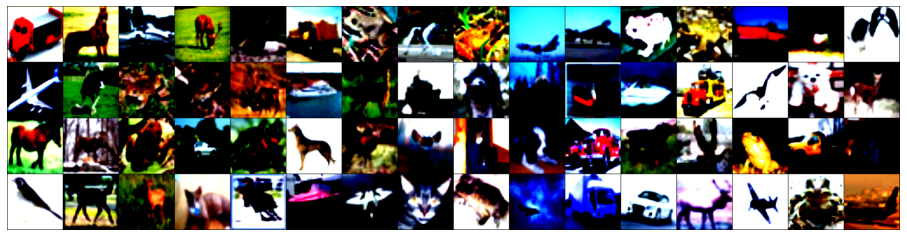

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [5]:
sample_image=iter(train_loader)
samples,labels=sample_image.next()
print(samples.shape) #64 batch size, 1 channel, width 224 , height 224
print(labels)

torch.Size([64, 3, 224, 224])
tensor([8, 2, 0, 6, 2, 5, 6, 8, 5, 5, 3, 9, 4, 8, 2, 7, 3, 0, 2, 9, 4, 2, 6, 6,
        9, 9, 6, 1, 7, 3, 6, 3, 1, 6, 5, 3, 5, 5, 5, 0, 9, 3, 8, 1, 9, 8, 7, 6,
        7, 6, 8, 1, 6, 0, 1, 8, 8, 8, 8, 0, 8, 2, 6, 6])


In [6]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}


class VGG_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types["VGG16"])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = VGG_net() 
model = model.to(device=device) 
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr) 

In [8]:
for epoch in range(num_epochs): #I decided to train the model for 50 epochs
    loss_var = 0
    
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device=device)
        labels = labels.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(images)
        loss = criterion(scores,labels)
        loss.backward()
        optimizer.step()
        loss_var += loss.item()
        if idx%64==0:
            print(f'Epoch [{epoch+1}/{num_epochs}] || Step [{idx+1}/{len(train_loader)}] || Loss:{loss_var/len(train_loader)}')
    print(f"Loss at epoch {epoch+1} || {loss_var/len(train_loader)}")
    with torch.no_grad():
        correct = 0
        samples = 0
        for idx, (images, labels) in enumerate(val_loader):
            images = images.to(device=device)
            labels = labels.to(device=device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum()
            samples += preds.size(0)
        print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")

Epoch [1/5] || Step [1/625] || Loss:0.011016004180908203
Epoch [1/5] || Step [65/625] || Loss:0.26041273307800294
Epoch [1/5] || Step [129/625] || Loss:0.45316972312927245
Epoch [1/5] || Step [193/625] || Loss:0.6307998950958252
Epoch [1/5] || Step [257/625] || Loss:0.7997085906982422
Epoch [1/5] || Step [321/625] || Loss:0.9630761476516724
Epoch [1/5] || Step [385/625] || Loss:1.1175798944473267
Epoch [1/5] || Step [449/625] || Loss:1.261861757659912
Epoch [1/5] || Step [513/625] || Loss:1.4026191215515136
Epoch [1/5] || Step [577/625] || Loss:1.5430471437454223
Loss at epoch 1 || 1.6407080251693726
accuracy 55.04 percentage || Correct 5504 out of 10000 samples
Epoch [2/5] || Step [1/625] || Loss:0.0020064306259155273
Epoch [2/5] || Step [65/625] || Loss:0.12608959817886353
Epoch [2/5] || Step [129/625] || Loss:0.24849448127746582
Epoch [2/5] || Step [193/625] || Loss:0.3696929654121399
Epoch [2/5] || Step [257/625] || Loss:0.48483878116607665
Epoch [2/5] || Step [321/625] || Loss:0.5